In [ ]:
# Settings for autoreloading.

%load_ext autoreload
%autoreload 2

In [ ]:
!pip install -r requirements.txt

In [ ]:
import wandb


wandb.login()

wandb: Currently logged in as: riccardo-spolaor94 (ai-industry). Use `wandb login --relogin` to force relogin


True

In [ ]:
from types import SimpleNamespace

# TODO: Some of these parameters are not used, remove them.
config = SimpleNamespace(
    noise_steps=1_000, # Number of noise steps on the diffusion process.
    sampler_steps=333, # Number of sampler steps on the diffusion process.
    model_name='unet_small', # Model name.
    seed=42, # Random seed.
    batch_size=256, # Batch size.
    img_size=64, # Image size.
    device='cuda', # Device to use.
    num_workers=0, # Number of workers for dataloader.
    num_input_frames=3, # Number of frames to use as input for the training.
    num_prediction_frames=3, # Number of predictions to make.
    num_channels=1, # Number of channels.
    )

In [ ]:
PROJECT_NAME = 'sevir'
DATASET_ARTIFACT = 'ai-industry/sevir/SEVIR:latest'
SCALERS_ARTIFACT = 'ai-industry/sevir/scalers:latest'

In [ ]:
import torch

from src.seeder import set_seed
from src.model import get_unet_params
from src.dataset_builder import download_dataset, download_scalers
from src.scaler import Scaler

# Set the model parameters in the config file.
# TODO: base num_frames on config
config.model_params = get_unet_params(
    model_name=config.model_name,
    num_input_frames=config.num_input_frames + config.num_prediction_frames,
    num_output_frames=config.num_prediction_frames,
    num_channels=config.num_channels
    )

# Set the seed and device.
set_seed(config.seed)
device = torch.device(config.device)

# Downlaod the dataset from the wandb Artifact.
files = download_dataset(DATASET_ARTIFACT, PROJECT_NAME)
scalers = download_scalers(SCALERS_ARTIFACT, PROJECT_NAME)

wandb: Downloading large artifact SEVIR:latest, 8544.38MB. 9 files... 
wandb:   9 of 9 files downloaded.  
Done. 0:0:37.9


wandb:   3 of 3 files downloaded.  


In [ ]:
events = [
    'Flash Flood',
    'Flood',
    'Funnel Cloud',
    'Hail',
    'Heavy Rain',
    'Lightning',
    'Thunderstorm Wind',
    'Tornado']

In [ ]:
from src.dataset_builder import CloudDataset
from src.dataloader import ValidationDataloader

events_dataloaders = {}

for event in events:
    # Build the test datasets.
    test_ds = CloudDataset(
        files=files[0:1], # Use just ir069 test images.
        num_frames=config.num_input_frames + config.num_prediction_frames, # Use 3 frames as input and 1 frame as prediction.
        img_size=config.img_size, # Image size.
        scalers=scalers[0:1], # Use just ir069 scaler.
        event_filter=event
        )

    test_dataloader = ValidationDataloader(
        test_ds,
        config.batch_size,
        n_past_frames=config.num_input_frames,
        shuffle=False,
        num_workers=config.num_workers)

    events_dataloaders[event] = test_dataloader

In [ ]:
from src.model import UNet3D
from src.sampler import ddim_sampler
from src.training import MiniTrainer

# Setup the model.
model = UNet3D(
    input_size=(1, 64, 64),
    n_past_frames=config.num_input_frames,
    n_prediction_frames=config.num_prediction_frames).to(device)

# Setup the sampler.
sampler = ddim_sampler(
    steps=config.sampler_steps,
    n_frames_to_predict=config.num_prediction_frames,
    n_channels=config.num_channels)


In [ ]:
from src.model import get_model_dictionary


model_dictionary = get_model_dictionary('unet_small:latest', 'cloud-diffuser-3D-no-autoregression')
model.load_state_dict(model_dictionary['model_state_dict'])

wandb: Downloading large artifact unet_small:latest, 239.75MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6


<All keys matched successfully>

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


test step for Flash Flood=1/1, test PSNR=37.249, test SSIM=0.848, test MSE=0.000, test mCSI=0.948


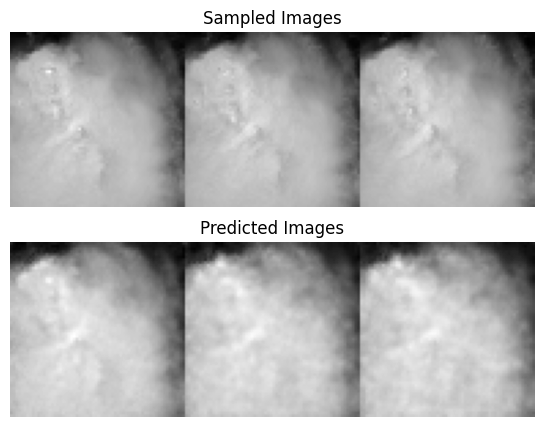

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


test step for Flood=1/1, test PSNR=36.278, test SSIM=0.863, test MSE=0.000, test mCSI=0.896


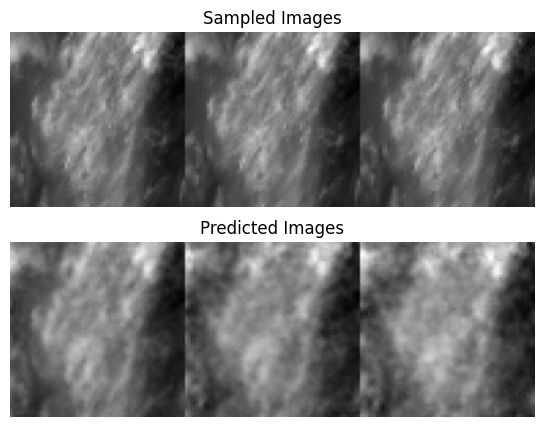

test step for Funnel Cloud=1/1, test PSNR=37.010, test SSIM=0.893, test MSE=0.000, test mCSI=0.872


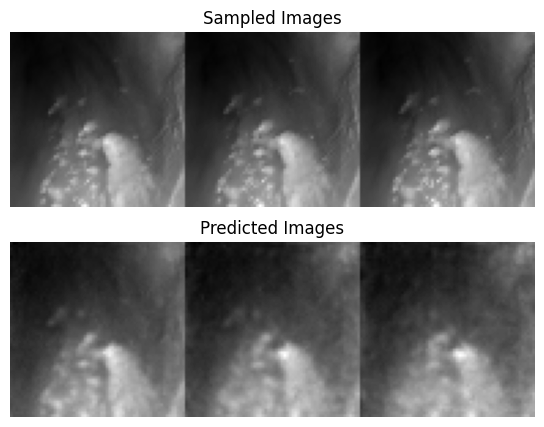

test step for Hail=1/1, test PSNR=38.432, test SSIM=0.849, test MSE=0.000, test mCSI=0.804


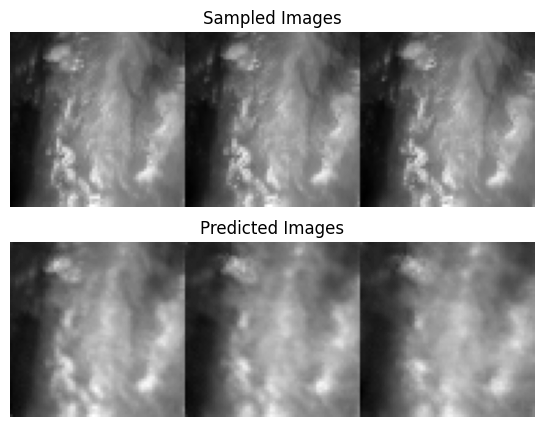

test step for Heavy Rain=1/1, test PSNR=39.102, test SSIM=0.896, test MSE=0.000, test mCSI=0.876


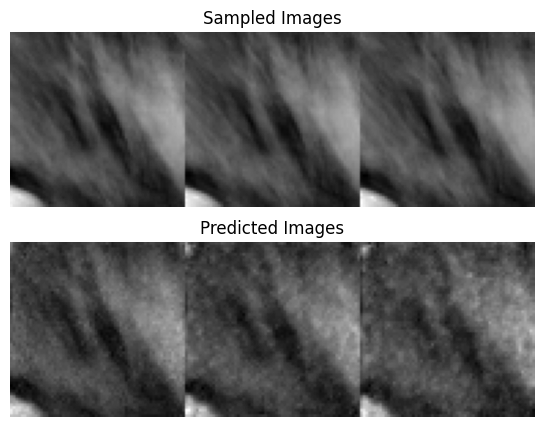

test step for Lightning=1/1, test PSNR=37.571, test SSIM=0.873, test MSE=0.000, test mCSI=0.917


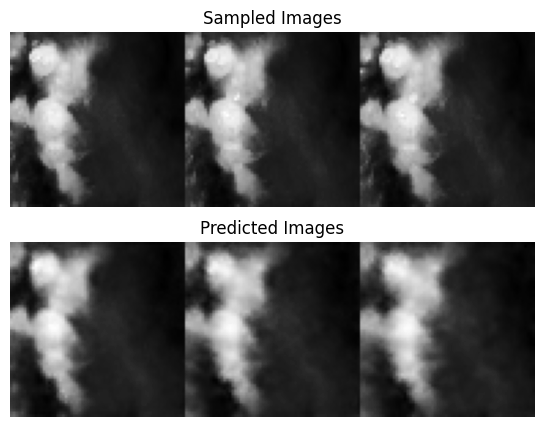

test step for Thunderstorm Wind=1/1, test PSNR=37.077, test SSIM=0.866, test MSE=0.000, test mCSI=0.945


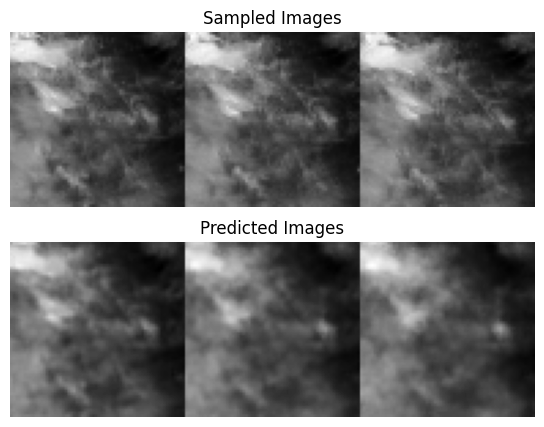

test step for Tornado=1/1, test PSNR=34.442, test SSIM=0.845, test MSE=0.000, test mCSI=0.893


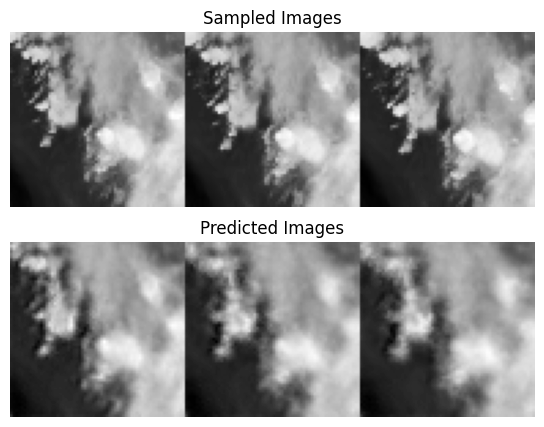

In [ ]:
from src.evaluation import Evaluator

events_results = {}

with wandb.init(
    project='test_evaluation',
    entity='ai-industry',
    config=config,
    tags=['ddpm', config.model_name]
    ):
    for k, v in events_dataloaders.items():
        evaluator = Evaluator(
            v,
            model,
            sampler,
            scalers[0],
            k,
            config.device,
            config.num_prediction_frames,
            n_auto_regression_steps=None,
            channels_per_image=config.num_channels)

        mse, psnr, ssim, m_csi = evaluator.evaluate()
        events_results[k] = {
            'mse': mse,
            'psnr': psnr,
            'ssim': ssim,
            'm_csi': m_csi}

    wandb.log(events_results)

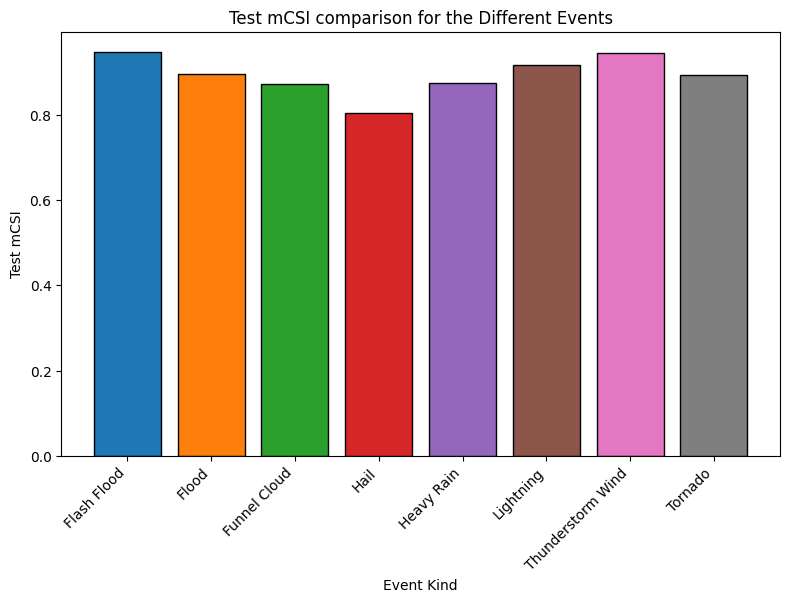

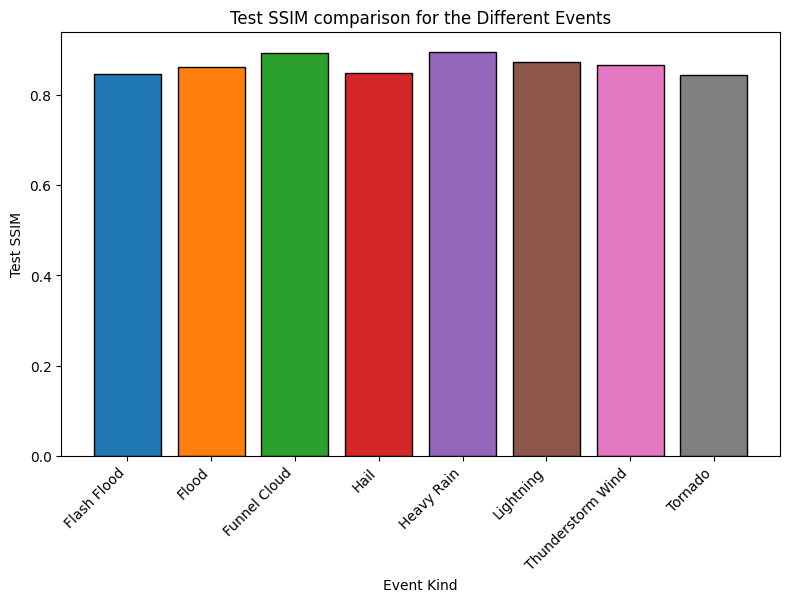

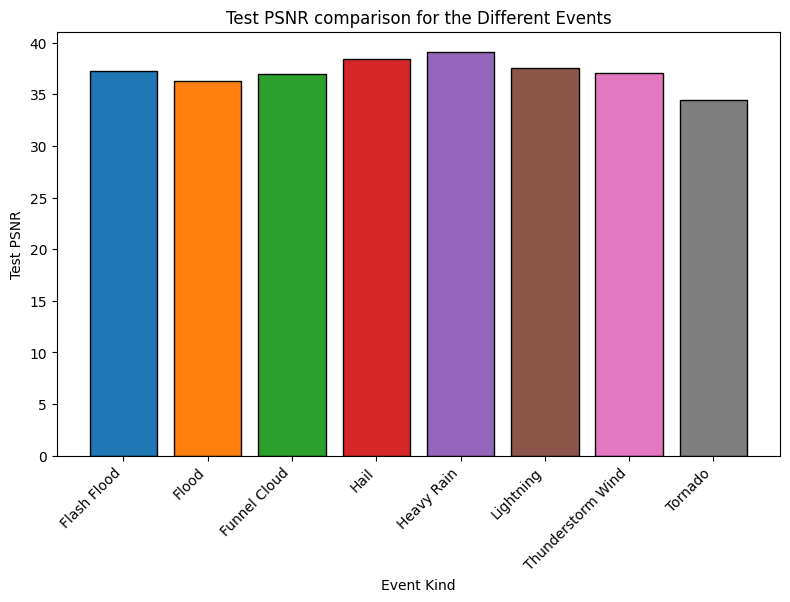

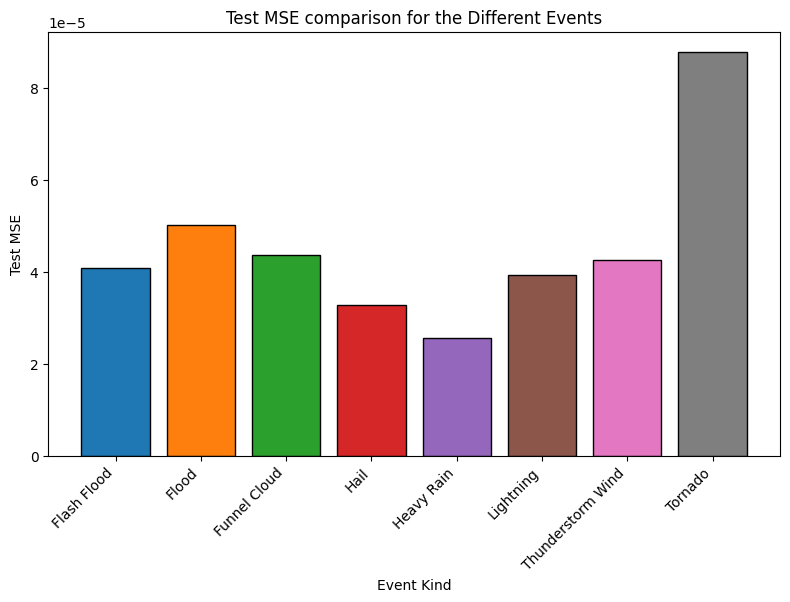

In [14]:
from src.visualization import plot_metric_on_test_set


plot_metric_on_test_set('m_csi', 'mCSI', events_results)
plot_metric_on_test_set('ssim', 'SSIM', events_results)
plot_metric_on_test_set('psnr', 'PSNR', events_results)
plot_metric_on_test_set('mse', 'MSE', events_results)